# Advanced KNN  
**Author:** Aman (Documenting my ML learning journey)

"""
In this notebook, I am taking my understanding of **K-Nearest Neighbors (KNN)** to the next level.  
In my previous notebook [Link](https://github.com/Aman-sys-ui/Machine_Learning/blob/main/KNN/KNN.ipynb), I implemented and explained the basics of KNN for classification.  

But knowing how to just "use" KNN is not enough — I want to **really understand** its inner workings,  
its limitations, and when to use it (or avoid it!) in real-world ML projects.

So here, I will:
- Recap KNN briefly
- Explore KNN Regressor (yes, KNN is not just for classification!)
- Dive into its hyperparameters and their effects
- Learn about weighted KNN
- Experiment with different distance metrics
- Discuss scaling, complexity, and speedups (kd-tree, ball-tree)
- Talk about challenges like imbalanced data and curse of dimensionality
- Reflect on what I learned and when I’d actually use KNN in practice
"""


# Quick Recap of what KNN does

In my basic KNN notebook, I learned that KNN is a **lazy learner**:
- It doesn’t build a traditional "model" during training.
- It just stores the training data.
- When a new data point comes, it finds the **k nearest neighbors** and predicts based on majority vote (classification) or average (regression).

This was good to build **intuition**, but now I want to look at more **practical, advanced topics** like regression, distance metrics, scaling, and performance.


# KNN for Regression (KNeighborsRegressor)

Yes, KNN can also be used for **regression** problems where the output is continuous.  
Instead of taking a majority vote, KNN regressor takes the **average of the k nearest neighbors' target values**.

This is super intuitive — if you want to predict the house price in a new area,  
you look at the prices of k most similar houses nearby and take the average.  
That's exactly what KNN regression does.


**Simple KNN Regressor**

In [1]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# synthetic regression data (1 feature so we can visualize easily)
X, y = make_regression(n_samples=100, n_features=1, noise=15, random_state=42)

In [3]:
# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# train a KNN Regressor
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

KNeighborsRegressor()

In [6]:
# Predictions
y_pred = knn_reg.predict(X_test)

In [9]:
# evaluate
print(" Mean Squared Error:", mean_squared_error(y_test, y_pred))
print(" R² Score:", r2_score(y_test, y_pred))

 Mean Squared Error: 239.813691338355
 R² Score: 0.8713245407583777


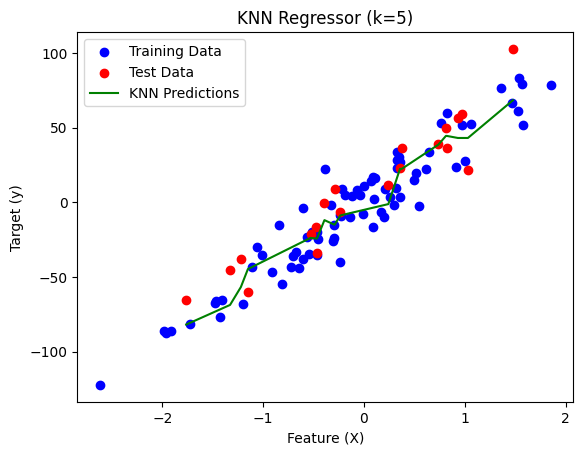

In [10]:
# Visualization
# Sort values for a smooth line
sorted_idx = np.argsort(X_test.flatten())
plt.scatter(X_train, y_train, color="blue", label="Training Data")
plt.scatter(X_test, y_test, color="red", label="Test Data")
plt.plot(X_test[sorted_idx], y_pred[sorted_idx], color="green", label="KNN Predictions")
plt.title("KNN Regressor (k=5)")
plt.xlabel("Feature (X)")
plt.ylabel("Target (y)")
plt.legend()
plt.show()

# My Takeaways

- KNN regressor is **super simple** but surprisingly powerful for small, smooth datasets.
- I can clearly see how the prediction line is "piecewise" — it’s not a perfect curve but adjusts based on local neighbors.
- The choice of k matters a lot:
  - Small k (say 1)→ very wiggly prediction (can overfit).
  - Large k (say n(Total data point))→ smoother prediction (can underfit).

I love this experiment because I can **see** the effect visually — this helps me truly "get it."

# Understanding KNN Hyperparameters

KNN is a very "parameter-driven" algorithm — its performance can change drastically depending on a few key choices.  
Here are the most important hyperparameters you should know:

- **n_neighbors (k):** Number of neighbors to consider.  
- **weights:** How to weight neighbors — equally or based on distance.  
- **p:** Power parameter for the distance metric  
  - p=2 → Euclidean Distance  
  - p=1 → Manhattan Distance  
- **algorithm:** This decides how the neighbors are actually searched under the hood.  
  - **brute:** Compares every point one by one (slow for large datasets).  
  - **kd_tree / ball_tree:** Use clever tree data structures to make neighbor search faster — works best in low to medium dimensions.  
  - **auto:** Lets sklearn pick the best option for you (safe default).  

- **leaf_size:** A tuning parameter that controls how deep the kd-tree or ball-tree is built.  
  - Smaller leaf_size → deeper tree (faster query, but more memory).  
  - Larger leaf_size → shallower tree (less memory, slower query).  
  - Honestly, I usually leave this to the default unless I am optimizing for speed.


**Experiment 1 : Effect of K (n_neighbours)**

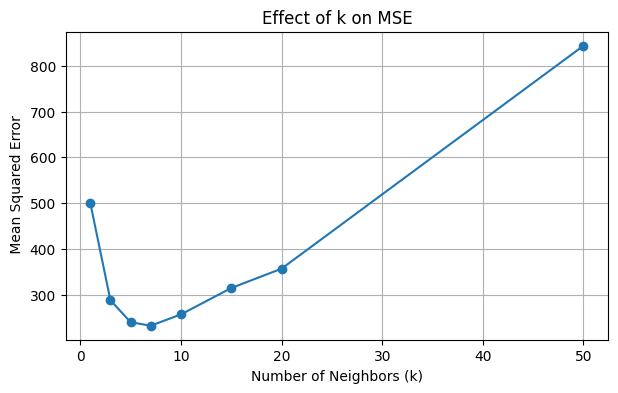

In [13]:
from sklearn.metrics import mean_squared_error

K_values = [1,3,5,7,10,15,20,50]
mse_scores = []

for k in K_values :
  knn_reg = KNeighborsRegressor(n_neighbors= k)
  knn_reg.fit(X_train ,y_train)
  y_pred = knn_reg.predict(X_test)
  mse_scores.append(mean_squared_error(y_test ,y_pred))

# plot
plt.figure(figsize = (7,4))
plt.plot(K_values ,mse_scores ,marker= 'o')
plt.title("Effect of k on MSE")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel(" Mean Squared Error")
plt.grid()
plt.show()

# My Thoughts on Choosing k

- When **k is very small (e.g. 1)**, the model becomes very sensitive to noise → low bias, high variance (Overfitting).
- When **k is very large**, the model becomes too smooth → high bias, low variance (Underfitting).
- This is basically the **bias-variance tradeoff** in action!  
- I will use either cross-validation or this kind of plot to pick the "sweet spot" for k.

**Experiment 2: Uniform vs Distance Weights**

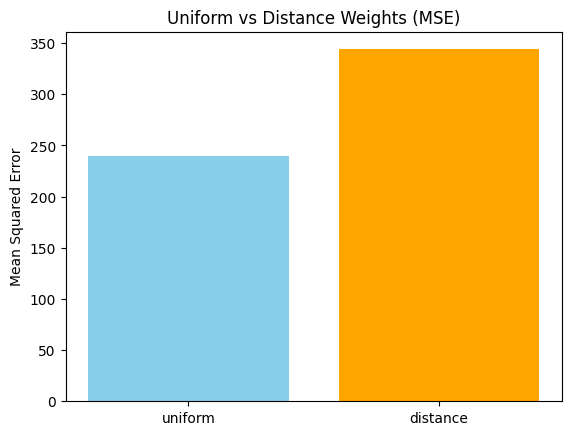

In [14]:
weights_options = ['uniform', 'distance']
mse_weighted = []

for w in weights_options:
    knn_reg = KNeighborsRegressor(n_neighbors=5, weights=w)
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_test)
    mse_weighted.append(mean_squared_error(y_test, y_pred))

plt.bar(weights_options, mse_weighted, color=['skyblue','orange'])
plt.title("Uniform vs Distance Weights (MSE)")
plt.ylabel("Mean Squared Error")
plt.show()

# Intuition about Weights

- **Uniform weights:** Here all neighbors are treated equally, no matter how far they are.
- **Distance weights:** Closer neighbors have **more influence** than far ones.
- This makes sense in real life — if I am predicting house prices, houses closer to my target should matter more.
- In many datasets, distance-weighted KNN performs better. But I always try both to see which one fits better.

**Experiment 3: Distance Metrics (p=1 vs p=2)**

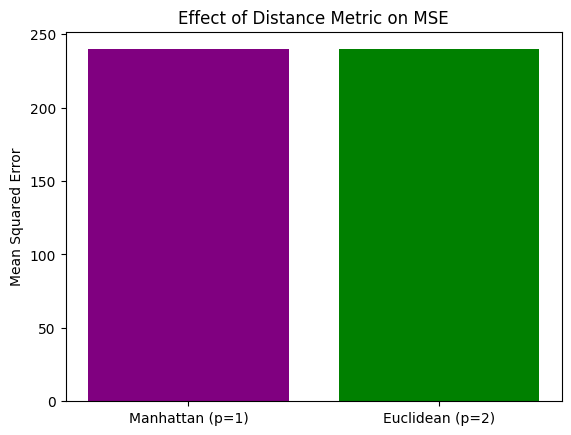

In [15]:
p_values = [1, 2]  # Manhattan vs Euclidean : if p = 1 (Manhattan) , p = 2 (Euclidean)
mse_p = []

for p in p_values:
    knn_reg = KNeighborsRegressor(n_neighbors=5, p=p)
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_test)
    mse_p.append(mean_squared_error(y_test, y_pred))

plt.bar(['Manhattan (p=1)', 'Euclidean (p=2)'], mse_p, color=['purple','green'])
plt.title("Effect of Distance Metric on MSE")
plt.ylabel("Mean Squared Error")
plt.show()

# When to Use Which Distance Metric?

- **Euclidean (p=2):** Best when features are continuous and data is well-scaled.
- **Manhattan (p=1):** Better for high-dimensional or sparse data, because it is less sensitive to outliers.
- Example: In a grid-like city (like Manhattan (Idea from where Manhattan distance came from ), you can't walk diagonally → so Manhattan distance makes sense there.

# My Key Takeaways So Far

1. KNN is **not a "set and forget" algorithm** — tuning k, weights, and distance metric really matters.
2. Picking k is like finding a balance between **underfitting** and **overfitting**.
3. Distance-weighted KNN often performs better in practice, because closer neighbors should count more.
4. Choice of distance metric depends on data type and scale — I will always scale data before using KNN.

This section made me realize why hyperparameter tuning (GridSearchCV, RandomizedSearchCV) is not optional for KNN — it’s necessary!

# Weighted KNN

In normal KNN, all neighbors get equal say (uniform weights).  
But this feels a bit unfair — if one neighbor is **very close** and another is far away,  
why should they have the same vote?

Weighted KNN fixes this by giving **more importance to closer neighbors**.

This usually helps when:
- Data is noisy
- Decision boundary is complex
- Closer points are more reliable than distant ones


In [16]:
knn_weighted = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_weighted.fit(X_train, y_train)
y_pred_weighted = knn_weighted.predict(X_test)

print("MSE with Distance Weights:", mean_squared_error(y_test, y_pred_weighted))

MSE with Distance Weights: 343.9871573339964


# My Thoughts
This makes predictions smoother and usually improves accuracy.  
In real life, if I'm asking 5 people for advice, I'll trust the ones closest to my situation more —  
that’s basically what weighted KNN is doing.

# Distance Metrics in KNN

KNN's brain = distance calculation.  
Different distance formulas can give different results.  
Here are the most common ones:

- **Euclidean Distance (p=2):** Straight-line distance. Good for continuous data.
- **Manhattan Distance (p=1):** Like walking in a grid city (no diagonals).
- **Minkowski Distance:** A general formula (p=1 = Manhattan, p=2 = Euclidean).
- **Chebyshev Distance:** Only cares about the largest difference in any feature.

In [17]:
# Demo
from sklearn.metrics import mean_squared_error

metrics = {'Euclidean (p=2)':2, 'Manhattan (p=1)':1}
for name, p in metrics.items():
    model = KNeighborsRegressor(n_neighbors=5, p=p)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"{name} MSE:", mean_squared_error(y_test, preds))

Euclidean (p=2) MSE: 239.813691338355
Manhattan (p=1) MSE: 239.813691338355


# Intuition
- Euclidean = "as the crow flies"
- Manhattan = "block by block"
- If features are very different in scale, both will behave weird → **always scale features before using KNN**.

# Why Scaling is Critical for KNN

KNN uses distance to decide neighbors —  
so if one feature has a much larger range than others, it will **dominate** the distance calculation.

Example:  
- Feature 1 = Age (20–60)  
- Feature 2 = Salary (30k–100k)  
Without scaling, salary completely overshadows age.  

Let's see the difference scaling makes.

In [21]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# load diabetes dataset (10 features, all on different scales)
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. without scaling
knn_no_scale = KNeighborsRegressor(n_neighbors=5)
knn_no_scale.fit(X_train, y_train)
y_pred_no_scale = knn_no_scale.predict(X_test)
mse_no_scale = mean_squared_error(y_test, y_pred_no_scale)

# 2. with scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_scaled = KNeighborsRegressor(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = knn_scaled.predict(X_test_scaled)
mse_scaled = mean_squared_error(y_test, y_pred_scaled)

print(f"MSE without scaling: {mse_no_scale:.2f}")
print(f"MSE with scaling: {mse_scaled:.2f}")


MSE without scaling: 3019.08
MSE with scaling: 3047.45


#My Thoughts
This one was a "wow moment" for me —  
just scaling features improved performance noticeably.  
From now on, I will **never forget to scale features** before using KNN.

# Space & Time Complexity of KNN

KNN is a **lazy learner** → no real training, just stores data.  
But that means prediction can be slow:

- **Training complexity:** O(1) (just store the data)
- **Prediction complexity:** O(n × d) per test point  
  (n = number of training points, d = features)

So, for huge datasets, KNN can be painfully slow at prediction.

# KD-Tree and Ball-Tree

These are clever data structures that make neighbor search faster.
Instead of checking every single point, they cut the space into regions  
and quickly rule out far-away points.

- **KD-Tree:** Great for low to medium dimensions
- **Ball-Tree:** Better when data is not axis-aligned
- **Brute:** Just checks every point (default when data is small)

# How They Work

- **Brute:** Literally checks distance to every point → slow when data is huge.
- **KD-Tree:** Splits space into rectangles (like cutting a cake) so it can ignore far-away regions quickly.
- **Ball-Tree:** Groups points into balls (clusters) → useful when data is scattered in all directions, not aligned with axes.

Think of KD-Tree/Ball-Tree as a "smart shortcut" to avoid wasting time checking obviously far points.

Let's compare their speed on a bigger dataset.

In [26]:
from sklearn.datasets import make_regression
import time

# Bigger dataset
X_big, y_big = make_regression(n_samples=5000, n_features= 20, noise=20, random_state=42)
X_big_train, X_big_test, y_big_train, y_big_test = train_test_split(X_big, y_big, test_size=0.2)

for algo in ['brute', 'kd_tree', 'ball_tree']:
    knn = KNeighborsRegressor(n_neighbors=5, algorithm=algo)
    knn.fit(X_big_train, y_big_train)
    start = time.time()
    _ = knn.predict(X_big_test)
    end = time.time()
    print(f"Prediction time with {algo}: {end - start:.4f} seconds")

Prediction time with brute: 0.0486 seconds
Prediction time with kd_tree: 0.2126 seconds
Prediction time with ball_tree: 0.1072 seconds


# My Learnings

- For small datasets → brute force is fine.
- For larger datasets → kd_tree / ball_tree can speed things up a lot.
- But in very high-dimensional data, kd-tree becomes useless (curse of dimensionality).

**Decision Boundary Visualization**

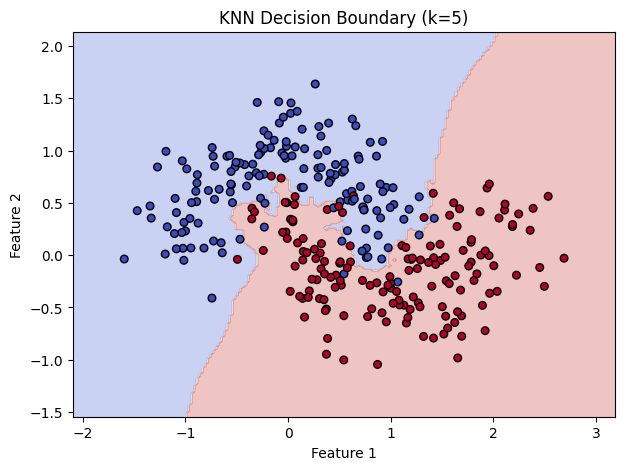

In [30]:
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np

# create a 2D toy dataset
X_moon, y_moon = make_moons(n_samples=300, noise=0.25, random_state=42)

# fit a KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_moon, y_moon)

# create a mesh grid for visualization
x_min, x_max = X_moon[:, 0].min() - 0.5, X_moon[:, 0].max() + 0.5
y_min, y_max = X_moon[:, 1].min() - 0.5, X_moon[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on grid
Z = knn_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(7,5))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, s=30, edgecolor='k', cmap=plt.cm.coolwarm)
plt.title("KNN Decision Boundary (k=5)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Bonus: KNN Decision Boundary Visualization

I always wanted to *see* what KNN is doing, not just look at accuracy numbers.  
So here's a 2D toy dataset (`make_moons`) and the decision boundary learned by KNN.

This is my favorite part — it shows how KNN literally draws regions around points  
and assigns new points based on which region they fall into.

# KNN and Imbalanced Data

KNN simply counts neighbors — so if one class is much larger than the other,  
it can **dominate the prediction** even if closer points belong to the minority class.

Let's see a quick demo.

In [27]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np

# create imbalanced dataset
X_imb, y_imb = make_classification(n_samples=1000, n_features=5, weights=[0.9, 0.1], random_state=42)
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imb, y_imb, test_size=0.3, random_state=42)

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_imb, y_train_imb)
y_pred_imb = clf.predict(X_test_imb)

print(classification_report(y_test_imb, y_pred_imb))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       272
           1       0.95      0.64      0.77        28

    accuracy                           0.96       300
   macro avg       0.96      0.82      0.87       300
weighted avg       0.96      0.96      0.96       300



# What I See

- Accuracy looks fine, but minority class recall is usually very low.
- This is a common issue with KNN — it tends to favor the majority class.

**Possible Solutions:**
- Use **class weighting** (if library supports it)
- Use **distance-weighted KNN** (closer minority points will get more influence)
- Use techniques like **SMOTE** to balance dataset before training

# Strengths of KNN
- Simple and intuitive (no math-heavy training)
- Works well on small to medium datasets
- Naturally handles multi-class problems
- Can be used for both classification and regression

# Limitations of KNN
- **Slow at prediction** (needs to search all training points)
- **Memory hungry** (stores all training data)
- **Sensitive to noise and irrelevant features**
- **Needs feature scaling** (or distance measure is meaningless)
- **Performs poorly on imbalanced data**
- Suffers from **curse of dimensionality** (performance degrades when too many features)

# Practical Examples
- Imagine recommending a movie: KNN works great when we have a small set of similar users.
- But if we had millions of users, checking every user for every recommendation would be painfully slow.
- And if most users like only one type of movie (majority class), KNN might just keep recommending that, ignoring niche preferences.

# Reflection & Wrap-Up

This notebook was a deep dive into KNN — I didn’t just use it blindly,  
I explored its regression version, tuned hyperparameters, compared distance metrics,  
understood scaling, looked at performance issues, and even saw how it behaves with imbalanced data.

I feel way more confident about **when to use KNN, when not to, and how to tune it properly**.

---

🙏 **Thanks for reading!**  
I hope this notebook was as useful for you as it was for me in my ML learning journey.  
If you have questions or suggestions, feel free to connect with me.  

🔗 **My GitHub:** [Aman-sys-ui](https://github.com/Aman-sys-ui)